<a href="https://colab.research.google.com/github/SridharaniKatipally/video-captioning-using-contextual-and-temporal-GANs/blob/main/Copy_of_final_Semi_executed_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import json
import zipfile
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

In [ ]:
# Load MSR-VTT JSON annotations
def load_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

In [ ]:
# Feature Extractor using ResNet-152 for spatial features
import torchvision.models as models
import torch.nn as nn

# Load pre-trained ResNet-152
feature_extractor = models.resnet152(pretrained=True)

# Remove the classification layer (`fc`) and keep only convolutional layers + avgpool
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()  # Set to evaluation mode

# Print ResNet architecture after removing `fc`
print(feature_extractor)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 102MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
from google.colab import drive

# This will prompt you to authorize Colab to access your Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

# Define paths
zip_path = "/content/drive/My Drive/filtered_videos.zip"
extract_path = "/content/extracted_videos"

# Get video IDs from JSON annotations
json_path = "/content/drive/My Drive/filtered_annotations.json"  # Update with your actual JSON file path
annotations = load_annotations(json_path)
expected_video_ids = {ann['image_id'] for ann in annotations['annotations']}

# Count extracted videos
extracted_video_ids = set()

# Open the zip file to inspect its contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_contents = zip_ref.namelist()
    for file in zip_contents:
        if file.endswith('.mp4'):
            video_id = os.path.splitext(os.path.basename(file))[0]
            extracted_video_ids.add(video_id)

# Get missing video IDs
missing_video_ids = expected_video_ids - extracted_video_ids

# Print results
print(f"✅ Number of videos in extracted zip: {len(extracted_video_ids)}")
if missing_video_ids:
    print(f"⚠️ Videos not extracted ({len(missing_video_ids)}): {missing_video_ids}")
else:
    print("✅ All expected videos were extracted.")

✅ Number of videos in extracted zip: 1520
✅ All expected videos were extracted.


In [ ]:
!unzip "/content/drive/My Drive/filtered_videos.zip" -d "/content/extracted_videos"

Archive:  /content/drive/My Drive/filtered_videos.zip
 extracting: /content/extracted_videos/video1183.mp4  
 extracting: /content/extracted_videos/video1729.mp4  
 extracting: /content/extracted_videos/video1291.mp4  
 extracting: /content/extracted_videos/video2310.mp4  
 extracting: /content/extracted_videos/video1023.mp4  
 extracting: /content/extracted_videos/video2022.mp4  
 extracting: /content/extracted_videos/video1443.mp4  
 extracting: /content/extracted_videos/video1845.mp4  
 extracting: /content/extracted_videos/video184.mp4  
 extracting: /content/extracted_videos/video1895.mp4  
 extracting: /content/extracted_videos/video1949.mp4  
 extracting: /content/extracted_videos/video1842.mp4  
 extracting: /content/extracted_videos/video1803.mp4  
 extracting: /content/extracted_videos/video226.mp4  
 extracting: /content/extracted_videos/video1244.mp4  
 extracting: /content/extracted_videos/video245.mp4  
 extracting: /content/extracted_videos/video1085.mp4  
 extracting: /

In [ ]:
from torchvision.transforms import ToPILImage

In [ ]:
# Video Dataset Loader
class VideoCaptionDataset(Dataset):
    def __init__(self, json_path, video_folder, transform=None):
        self.annotations = load_annotations(json_path)
        self.video_folder = video_folder
        self.transform = transform
        # Import resnet18 from torchvision.models
        from torchvision.models import resnet18 # Import resnet18 here
        import torch.nn as nn
        self.feature_extractor = resnet18(weights="IMAGENET1K_V1").to(device)  # Use 'weights' instead of 'pretrained'
        self.feature_extractor.fc = nn.Identity()  # Remove the classification layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # Ensure fixed feature size
        # ... rest of your code ...

        # Extract video IDs from annotations and available files
        #annotation_video_ids = set(ann['image_id'] for ann in self.annotations['annotations'])
        #available_video_ids = {f.split('.')[0] for f in os.listdir(video_folder) if f.endswith('.mp4')}
        #self.valid_video_ids = annotation_video_ids & available_video_ids

        # Filter annotations to only include existing videos
        #self.annotations['annotations'] = [
        #   ann for ann in self.annotations['annotations'] if ann['image_id'] in self.valid_video_ids
        #]

        print(f"✅ Filtered dataset to {len(self.annotations['annotations'])} valid annotations.")

    def __len__(self):
        return len(self.annotations['annotations'])

    def __getitem__(self, idx):
        from PIL import Image  # Import explicitly inside the method

        annotation = self.annotations['annotations'][idx]
        video_id = annotation['image_id']
        video_path = os.path.join(self.video_folder, f"{video_id}.mp4")

        # Extract frames
        frames = self.extract_frames(video_path)
        if len(frames) == 0:
            print(f"⚠️ Skipping video {video_path} due to empty frames.")
            return None

        # Transform and stack frames
        try:
            frames = [self.transform(Image.fromarray(frame.permute(1, 2, 0).numpy())) for frame in frames]
            frames = torch.stack(frames)
        except Exception as e:
            print(f"❌ Error transforming frames for video {video_path}: {e}")
            return None

        # Convert caption to tensor (simple char-to-ASCII for demonstration)
        caption_text = annotation.get('caption', "")
        if isinstance(caption_text, str):
            caption_tensor = torch.tensor([ord(c) for c in caption_text], dtype=torch.long)
        else:
            caption_tensor = torch.tensor([0], dtype=torch.long)

        return frames, caption_tensor

    def extract_frames(self, video_path, num_frames=16):
        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames == 0:
            return []

        indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
        for i in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = frame.astype(np.uint8)

                if frame.ndim == 3 and frame.shape[2] == 3:
                    frames.append(torch.tensor(frame).permute(2, 0, 1))
                else:
                    print(f"⚠️ Skipping frame with unexpected shape: {frame.shape}")
            else:
                print(f"⚠️ Failed to read frame at index {i} from {video_path}")

        cap.release()
        return frames

In [ ]:
# Define transformations for frames
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Custom collate function to handle padding for variable-length captions
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.zeros((1, 16, 3, 224, 224)), torch.zeros((1,), dtype=torch.long)

    videos, captions = zip(*batch)
    captions = pad_sequence(captions, batch_first=True, padding_value=0)
    return torch.stack(videos), captions

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [ ]:
# Load dataset
dataset = VideoCaptionDataset(
    json_path='/content/drive/My Drive/filtered_annotations.json',
    video_folder='/content/drive/My Drive/filtered_videos_.zip',
    transform=transform
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.5MB/s]


✅ Filtered dataset to 30400 valid annotations.


In [ ]:
from sklearn.model_selection import train_test_split

import json

import os



# Load annotations from JSON

def load_annotations(json_path):

    with open(json_path, 'r') as f:

        data = json.load(f)

    return data



json_path = "/content/drive/My Drive/filtered_annotations.json"

annotations = load_annotations(json_path)



# Extract unique video IDs from annotations

video_ids = list(set(ann["image_id"] for ann in annotations["annotations"]))



# Split video IDs into 80% train, 20% test

train_video_ids, test_video_ids = train_test_split(video_ids, test_size=0.2, random_state=42)



print(f"✅ Train Videosids: {len(train_video_ids)}, Test Videosids: {len(test_video_ids)}")

✅ Train Videosids: 1216, Test Videosids: 304


In [ ]:
# Filter annotations for train and test
train_annotations = {"annotations": [ann for ann in annotations["annotations"] if ann["image_id"] in train_video_ids]}
test_annotations = {"annotations": [ann for ann in annotations["annotations"] if ann["image_id"] in test_video_ids]}

# Save new train and test annotation files
train_json_path = "/content/drive/My Drive/train_annotations.json"
test_json_path = "/content/drive/My Drive/test_annotations.json"

with open(train_json_path, "w") as f:
    json.dump(train_annotations, f, indent=4)

with open(test_json_path, "w") as f:
    json.dump(test_annotations, f, indent=4)

print("✅ Train and Test annotations saved!")

✅ Train and Test annotations saved!


In [ ]:
import shutil

# Define paths
video_folder = "/content/extracted_videos/"
train_video_folder = "/content/extracted_videos/train/"
test_video_folder = "/content/extracted_videos/test/"

# Create directories if they don't exist
os.makedirs(train_video_folder, exist_ok=True)
os.makedirs(test_video_folder, exist_ok=True)

# Move train videos
for video_id in train_video_ids:
    video_path = os.path.join(video_folder, f"{video_id}.mp4")
    if os.path.exists(video_path):
        shutil.move(video_path, os.path.join(train_video_folder, f"{video_id}.mp4"))

# Move test videos
for video_id in test_video_ids:
    video_path = os.path.join(video_folder, f"{video_id}.mp4")
    if os.path.exists(video_path):
        shutil.move(video_path, os.path.join(test_video_folder, f"{video_id}.mp4"))

print(f"✅ Videos moved: {len(train_video_ids)} in Train, {len(test_video_ids)} in Test.")

✅ Videos moved: 1216 in Train, 304 in Test.


In [ ]:
# Load Train Dataset
train_dataset = VideoCaptionDataset(
    json_path=train_json_path,
    video_folder=train_video_folder,
    transform=transform
)
# For quick testing, use a smaller dataset
dataset.annotations['annotations'] = dataset.annotations['annotations'][:2000]

# Load Test Dataset
test_dataset = VideoCaptionDataset(
    json_path=test_json_path,
    video_folder=test_video_folder,
    transform=transform
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2)

print(f"✅ Train Dataset: {len(train_dataset)} samples, Test Dataset: {len(test_dataset)} samples")

✅ Filtered dataset to 24320 valid annotations.
✅ Filtered dataset to 6080 valid annotations.
✅ Train Dataset: 24320 samples, Test Dataset: 6080 samples


24,320 samples (annotations + videos) in the train set (80%). 6,080 samples (annotations + videos) in the test set (20%).

In [ ]:
train_video_ids = set(ann["image_id"] for ann in train_annotations["annotations"])
test_video_ids = set(ann["image_id"] for ann in test_annotations["annotations"])

# Check for overlap
overlap = train_video_ids & test_video_ids
if len(overlap) == 0:
    print("✅ No overlapping videos between Train and Test sets.")
else:
    print(f"❌ Warning! {len(overlap)} videos are in both Train and Test sets.")

✅ No overlapping videos between Train and Test sets.


In [ ]:
import os

# Check for missing train videos
missing_train_videos = [vid for vid in train_video_ids if not os.path.exists(os.path.join(train_video_folder, f"{vid}.mp4"))]
# Check for missing test videos
missing_test_videos = [vid for vid in test_video_ids if not os.path.exists(os.path.join(test_video_folder, f"{vid}.mp4"))]

if len(missing_train_videos) == 0:
    print("✅ All train videos exist.")
else:
    print(f"⚠️ Missing {len(missing_train_videos)} train videos!")

if len(missing_test_videos) == 0:
    print("✅ All test videos exist.")
else:
    print(f"⚠️ Missing {len(missing_test_videos)} test videos!")

✅ All train videos exist.
✅ All test videos exist.


In [ ]:
train_ann_videos = {ann["image_id"] for ann in train_annotations["annotations"]}
test_ann_videos = {ann["image_id"] for ann in test_annotations["annotations"]}

if train_ann_videos == train_video_ids:
    print("✅ All Train annotations match Train videos.")
else:
    print("❌ Train annotations do not match Train videos.")

if test_ann_videos == test_video_ids:
    print("✅ All Test annotations match Test videos.")
else:
    print("❌ Test annotations do not match Test videos.")

✅ All Train annotations match Train videos.
✅ All Test annotations match Test videos.


In [ ]:
# Contextual Generator using CNN features
class ContextualGenerator(nn.Module):
    def __init__(self):
        super(ContextualGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2048, 256),  # Changed input size to 2048 to match ResNet-152 output
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
# Temporal Generator using LSTM
class TemporalGenerator(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, num_layers=2):
        super(TemporalGenerator, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 128)

    def forward(self, x):
        output, _ = self.lstm(x)
        return self.fc(output)

In [ ]:
class CaptionDecoder(nn.Module):

    def __init__(self, input_size=2048, vocab_size=1000, embedding_dim=256, hidden_size=256):

        super(CaptionDecoder, self).__init__()



        # Linear layer to transform ResNet features from 2048 -> embedding_dim

        self.fc_resnet = nn.Linear(input_size, embedding_dim)



        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, vocab_size)



    def forward(self, features, captions):

        # Transform ResNet features

        features = self.fc_resnet(features).unsqueeze(1)  # (batch_size, 1, embedding_dim)



        # Embed captions

        captions = self.embedding(captions)



        # Concatenate image features + captions

        inputs = torch.cat((features, captions), dim=1)



        # Pass through LSTM

        output, _ = self.lstm(inputs)



        return self.fc(output)

In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=128, num_layers=2):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        return self.sigmoid(self.fc(output[:, -1, :]))

In [ ]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

In [ ]:
# Loss and Optimizers
criterion = nn.CrossEntropyLoss()
bce_loss = nn.BCELoss()
contextual_generator = ContextualGenerator().to(device)
temporal_generator = TemporalGenerator().to(device)
decoder = CaptionDecoder(vocab_size=1000).to(device)
discriminator = Discriminator(vocab_size=1000).to(device)

optimizer_cg = optim.Adam(contextual_generator.parameters(), lr=0.0002)
optimizer_tg = optim.Adam(temporal_generator.parameters(), lr=0.0002)
optimizer_decoder = optim.Adam(decoder.parameters(), lr=0.0002)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002)
loss_fn = nn.BCELoss().to(device).half()
criterion = nn.CrossEntropyLoss().to(device).half()

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
from torchvision.models import resnet152, ResNet152_Weights

model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)

In [ ]:
import time
import gc  # For garbage collection
import torch

def train(train_dataset, epochs=5, feature_extractor=None,batch_size=32):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=2, collate_fn=collate_fn)  # ✅ Use custom collate function
  for epoch in range(epochs):
        print(f"\n🟢 Starting Epoch {epoch + 1}")
        total_loss_gen = 0
        total_loss_dis = 0
        start_epoch = time.time()

        for batch_idx, (features, captions) in enumerate(train_loader):
            batch_start = time.time()

            # Skip empty or invalid batches
            if features.shape[0] == 1 and torch.sum(features) == 0:
                continue

            # Move data to GPU
            features = features.to(device, non_blocking=True)
            captions = captions.to(device, non_blocking=True)

            # Extract features using ResNet152
            batch_size, num_frames, channels, height, width = features.shape
            features = features.view(batch_size * num_frames, channels, height, width)

            with torch.no_grad():
                features = feature_extractor(features)

            features = features.view(batch_size, num_frames, -1)
            features = features.mean(dim=1)  # Temporal aggregation

            # ======= Train Generators =======
            optimizer_cg.zero_grad()
            context_features = contextual_generator(features)

            optimizer_tg.zero_grad()
            temporal_features = temporal_generator(context_features.unsqueeze(1))

            optimizer_decoder.zero_grad()
            generated_captions = decoder(temporal_features.squeeze(1).long())

            # Align lengths for loss calculation
            gen_len = generated_captions.shape[1]
            target_len = captions.shape[1]
            min_len = min(gen_len, target_len)

            loss_gen = criterion(
                generated_captions[:, :min_len, :].reshape(-1, generated_captions.shape[-1]),
                captions[:, :min_len].reshape(-1)
            )

            loss_gen.backward()
            optimizer_cg.step()
            optimizer_tg.step()
            optimizer_decoder.step()

            total_loss_gen += loss_gen.item()

            # ======= Train Discriminator =======
            optimizer_discriminator.zero_grad()
            real_labels = torch.ones(captions.size(0), 1).to(device)
            fake_labels = torch.zeros(captions.size(0), 1).to(device)

            real_loss = bce_loss(discriminator(captions[:, :gen_len]), real_labels)
            fake_loss = bce_loss(discriminator(generated_captions.argmax(dim=-1)), fake_labels)
            loss_dis = (real_loss + fake_loss) / 2

            loss_dis.backward()
            optimizer_discriminator.step()

            total_loss_dis += loss_dis.item()

            batch_end = time.time()

            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx + 1} | Gen Loss: {loss_gen.item():.4f} | Dis Loss: {loss_dis.item():.4f} | Time: {batch_end - batch_start:.2f}s")

            # Free GPU memory every 100 batches
            if batch_idx % 100 == 0:
                gc.collect()
                torch.cuda.empty_cache()

        end_epoch = time.time()
        avg_loss_gen = total_loss_gen / len(dataloader)
        avg_loss_dis = total_loss_dis / len(dataloader)

        print(f"✅ Epoch {epoch + 1} Completed - Avg Gen Loss: {avg_loss_gen:.4f}, Avg Dis Loss: {avg_loss_dis:.4f} | Epoch Time: {end_epoch - start_epoch:.2f}s")

# Initialize the feature extractor
from torchvision.models import resnet152

feature_extractor = resnet152(pretrained=True).to(device)
feature_extractor.fc = nn.Identity()  # Remove the classification layer

# Train the model
train(train_dataset, epochs=5, feature_extractor=feature_extractor)


🟢 Starting Epoch 1
Batch 1 | Gen Loss: 5.6555 | Dis Loss: 0.4353 | Time: 0.32s
Batch 11 | Gen Loss: 4.8154 | Dis Loss: 0.2997 | Time: 0.32s
Batch 21 | Gen Loss: 4.3691 | Dis Loss: 0.2817 | Time: 0.26s
Batch 31 | Gen Loss: 3.8157 | Dis Loss: 0.1230 | Time: 0.27s
Batch 41 | Gen Loss: 3.6777 | Dis Loss: 0.0831 | Time: 0.25s
Batch 51 | Gen Loss: 3.4635 | Dis Loss: 0.0437 | Time: 0.25s
Batch 61 | Gen Loss: 3.2866 | Dis Loss: 0.0242 | Time: 0.30s
Batch 71 | Gen Loss: 3.2281 | Dis Loss: 0.0177 | Time: 0.28s
Batch 81 | Gen Loss: 3.0333 | Dis Loss: 0.0148 | Time: 0.26s
Batch 91 | Gen Loss: 3.0233 | Dis Loss: 1.9714 | Time: 0.30s
Batch 101 | Gen Loss: 3.2641 | Dis Loss: 1.3841 | Time: 0.30s
Batch 111 | Gen Loss: 2.8955 | Dis Loss: 0.9488 | Time: 0.29s
Batch 121 | Gen Loss: 3.3282 | Dis Loss: 0.7448 | Time: 0.28s
Batch 131 | Gen Loss: 3.0234 | Dis Loss: 0.1885 | Time: 0.26s
Batch 141 | Gen Loss: 2.9380 | Dis Loss: 0.6944 | Time: 0.28s
Batch 151 | Gen Loss: 2.9137 | Dis Loss: 0.6585 | Time: 0.27s

In [ ]:
# Save the trained models
torch.save(contextual_generator.state_dict(), "contextual_generator.pth")
torch.save(temporal_generator.state_dict(), "temporal_generator.pth")
torch.save(decoder.state_dict(), "caption_decoder.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

print("✅ Trained models saved successfully!")


✅ Trained models saved successfully!


In [ ]:
# Load the saved models
contextual_generator.load_state_dict(torch.load("contextual_generator.pth"))
temporal_generator.load_state_dict(torch.load("temporal_generator.pth"))
decoder.load_state_dict(torch.load("caption_decoder.pth"))
discriminator.load_state_dict(torch.load("discriminator.pth"))

# Move models to the appropriate device (GPU or CPU)
contextual_generator.to(device)
temporal_generator.to(device)
decoder.to(device)
discriminator.to(device)

print("✅ Trained models loaded successfully and ready for inference!")


✅ Trained models loaded successfully and ready for inference!


In [ ]:
# Build vocabulary from captions
def build_vocab(captions, min_freq=1):
    from collections import Counter
    counter = Counter()

    for ann in captions['annotations']:
        counter.update(ann['caption'].lower().split())

    vocab = {'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3}
    index = 4
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = index
            index += 1
    return vocab

# Load and build vocabulary
json_path = "/content/drive/My Drive/filtered_annotations.json"
captions_data = load_annotations(json_path)
vocab = build_vocab(captions_data)
inv_vocab = {idx: word for word, idx in vocab.items()}

print(f"✅ Vocabulary size: {len(vocab)}")

✅ Vocabulary size: 11308


In [ ]:
def decode_caption(caption_tokens):
    words = [inv_vocab.get(token.item(), "<UNK>") for token in caption_tokens]
    return " ".join(words)


print("Vocabulary:", inv_vocab)


In [ ]:
frames = extract_frames("/content/extracted_videos/test/video2125.mp4")
print(f"Extracted {len(frames)} frames from the video.")


Extracted 16 frames from the video.


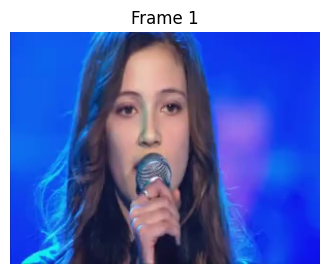

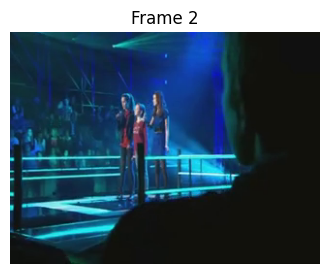

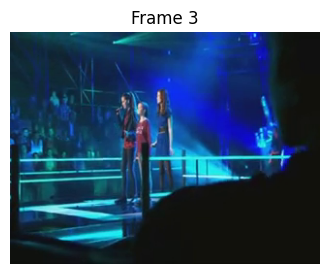

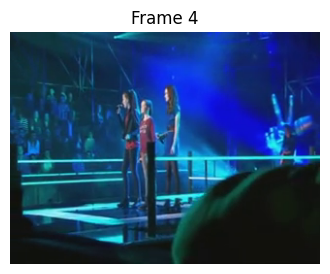

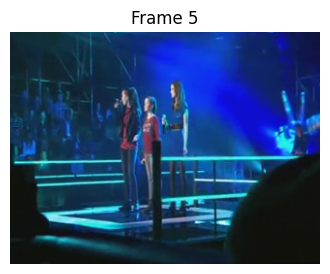

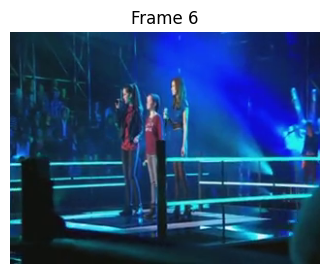

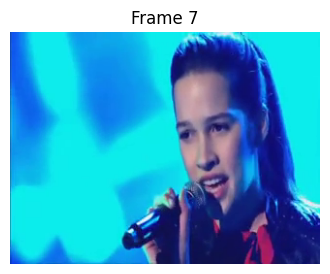

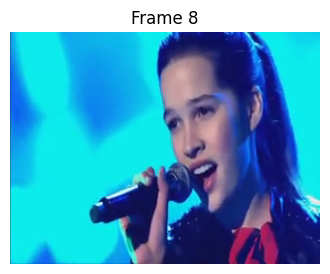

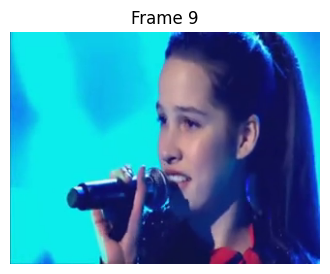

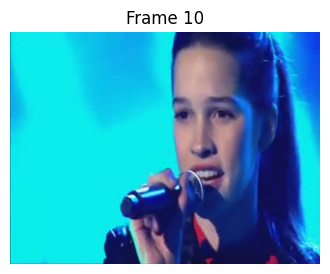

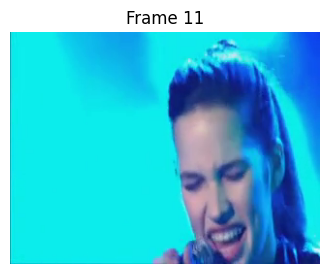

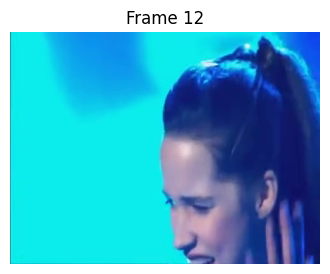

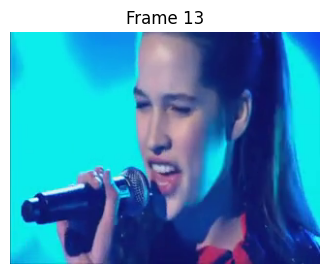

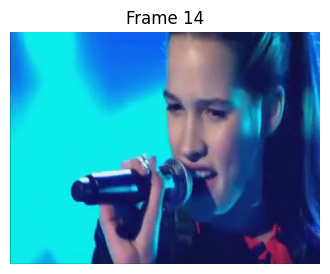

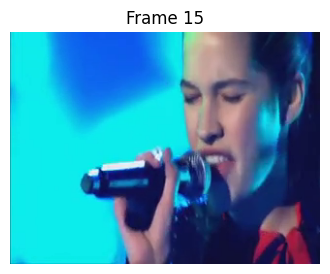

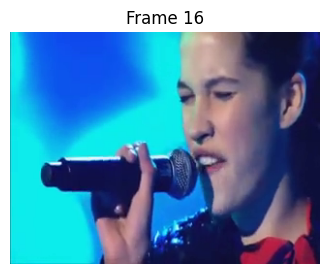

In [ ]:
import matplotlib.pyplot as plt

frames = extract_frames("/content/extracted_videos/test/video2125.mp4")  # Extract frames

for i, frame in enumerate(frames):
    frame_np = frame.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

    plt.figure(figsize=(4, 4))
    plt.imshow(frame_np)
    plt.axis("off")
    plt.title(f"Frame {i+1}")
    plt.show()


In [ ]:
import os
from PIL import Image

save_path = "extracted_frames1"
os.makedirs(save_path, exist_ok=True)  # Create folder if it doesn't exist

for i, frame in enumerate(frames):
    frame_np = frame.permute(1, 2, 0).numpy()  # Convert back to NumPy
    img = Image.fromarray(frame_np)
    img.save(f"{save_path}/frame_{i+1}.jpg")

print(f"✅ Frames saved to {save_path}/")


✅ Frames saved to extracted_frames1/


In [ ]:
frames = extract_frames("/content/extracted_videos/train/video16.mp4")
print(f"Extracted {len(frames)} frames from the video.")


Extracted 16 frames from the video.


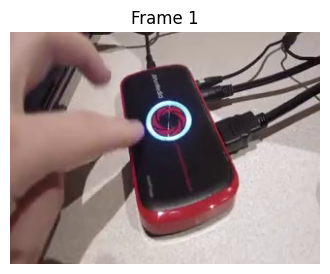

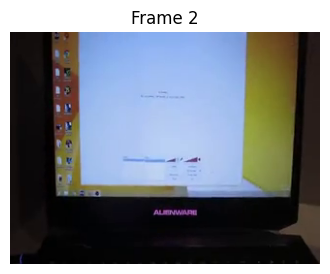

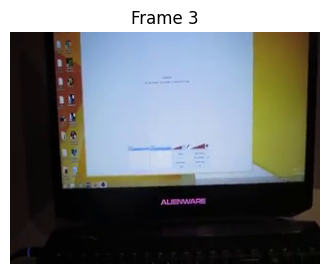

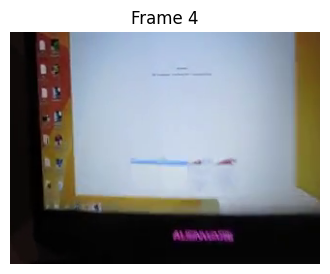

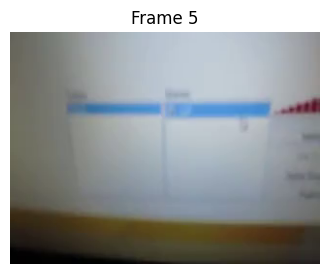

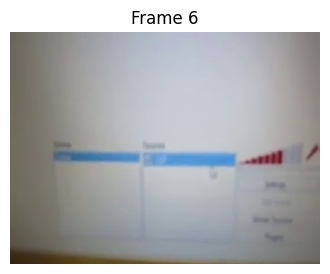

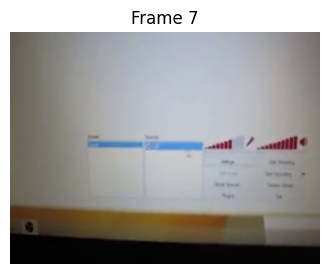

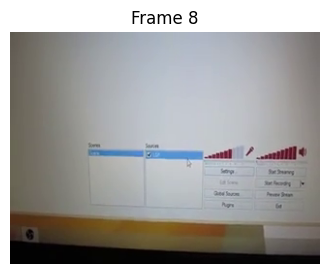

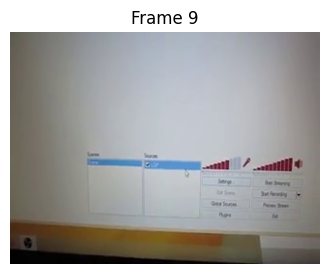

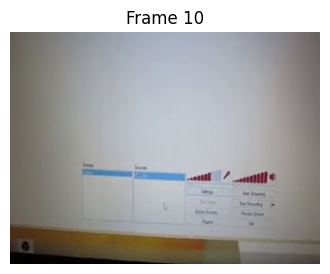

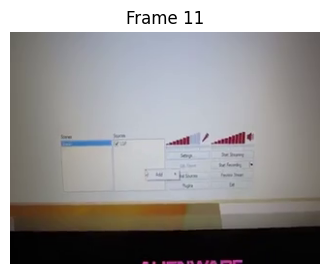

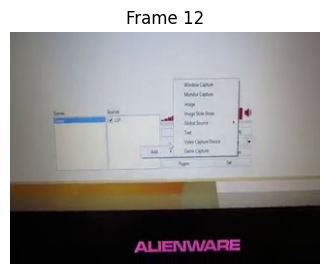

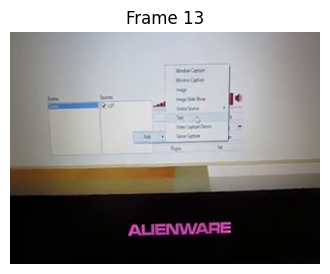

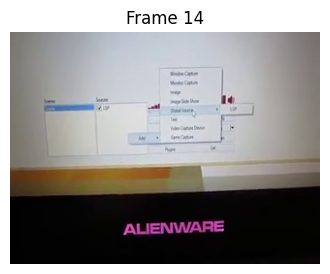

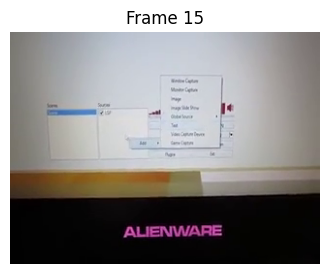

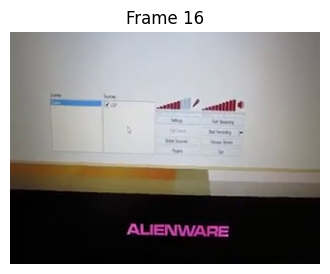

In [ ]:
import matplotlib.pyplot as plt

frames = extract_frames("/content/extracted_videos/train/video16.mp4")  # Extract frames

for i, frame in enumerate(frames):
    frame_np = frame.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

    plt.figure(figsize=(4, 4))
    plt.imshow(frame_np)
    plt.axis("off")
    plt.title(f"Frame {i+1}")
    plt.show()


In [ ]:
import os
from PIL import Image

save_path = "extracted_frames"
os.makedirs(save_path, exist_ok=True)  # Create folder if it doesn't exist

for i, frame in enumerate(frames):
    frame_np = frame.permute(1, 2, 0).numpy()  # Convert back to NumPy
    img = Image.fromarray(frame_np)
    img.save(f"{save_path}/frame_{i+1}.jpg")

print(f"✅ Frames saved to {save_path}/")


✅ Frames saved to extracted_frames/


In [ ]:
def generate_caption(video_path, transform, feature_extractor, contextual_generator, temporal_generator, decoder, vocab, max_length=20):
    frames = extract_frames(video_path)
    if not frames:
        return "❌ No frames extracted from the video."

    transformed_frames = [transform(Image.fromarray(frame.permute(1, 2, 0).numpy())).unsqueeze(0) for frame in frames]
    transformed_frames = torch.cat(transformed_frames).to(device)

    with torch.no_grad():
        features = feature_extractor(transformed_frames)

    features = features.mean(dim=0).unsqueeze(0)
    context_features = contextual_generator(features)
    temporal_features = temporal_generator(context_features.unsqueeze(1))

    input_token = torch.tensor([[vocab['<START>']]], dtype=torch.long).to(device)
    generated_tokens = []
    prev_token = None
    max_repeats = 2
    repeat_count = 0

    for _ in range(max_length):
        output = decoder(input_token)
        probabilities = torch.nn.functional.softmax(output[:, -1, :], dim=-1)
        predicted_token = torch.multinomial(probabilities, num_samples=1).item()

        if predicted_token == vocab.get('<END>', -1):
            break

        if predicted_token == prev_token:
            repeat_count += 1
            if repeat_count >= max_repeats:
                continue
        else:
            repeat_count = 0

        generated_tokens.append(predicted_token)
        prev_token = predicted_token
        input_token = torch.tensor([[predicted_token]], dtype=torch.long).to(device)

    inv_vocab = {idx: word for word, idx in vocab.items()}
    generated_caption = ' '.join([inv_vocab.get(token, '<UNK>') for token in generated_tokens])

    return generated_caption or "❌ No meaningful caption generated."

In [ ]:
generated_caption = generate_caption(
    video_path="/content/extracted_videos//video2125.mp4",
    transform=transform,
    feature_extractor=feature_extractor,
    contextual_generator=contextual_generator,
    temporal_generator=temporal_generator,
    decoder=decoder,
    vocab=vocab
)

print("📝 Generated Caption:", generated_caption)



Generated caption:A girl is Singing


In [ ]:
# Evaluate model
references, hypotheses = evaluate_model(decoder, train_loader)

# Compute evaluation metrics
bleu, meteor, rouge_l, cider = compute_scores(references, hypotheses)

# Print final evaluation scores
print(f"\n📊 Model Evaluation Scores:")
print(f"🔹 BLEU Score: {bleu:.4f}")
print(f"🔹 METEOR Score: {meteor:.4f}")
print(f"🔹 ROUGE-L Score: {rouge_l:.4f}")
print(f"🔹 CIDEr Score: {cider:.4f}")


In [ ]:
# Loss values from your training log
gen_losses = [2.9293, 2.7361, 2.7257, 2.7099, 2.7055]
dis_losses = [0.1647, 0.0093, 0.0010, 0.0004, 0.0002]
epochs = [1, 2, 3, 4, 5]


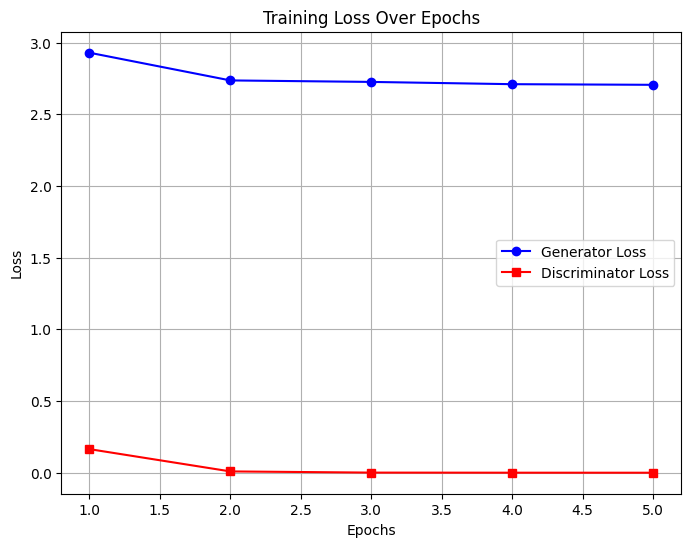

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(gen_losses, dis_losses, epochs):
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, gen_losses, label="Generator Loss", marker='o', linestyle='-', color="blue")
    plt.plot(epochs, dis_losses, label="Discriminator Loss", marker='s', linestyle='-', color="red")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot loss graph
plot_losses(gen_losses, dis_losses, epochs)


graph shows a good trend for training, but with some observations:

✅ Generator loss decreasing gradually → Indicates the model is learning to generate better captions. ✅ Discriminator loss approaching zero → Means the discriminator is struggling to differentiate real vs. generated captions, implying the generator is improving.